## Import libraries and Read in Data
2 files - Daily Stock price data, Sector mapping file

# PowerAI 5.1 Environment support - py2 / tflow 1.5 / xxx


In [1]:
ENV="dustinsmac" # dustinsmac / nimbix
if(ENV == "dustinsmac") : 
    rootdir = "/data/work/git-repos/mldl-101/labxx-eigenportfolios/"
    rootdir1 = "/data/work/osa/2018-04-eigenportfolios/Deep-Portfolio-Theory/"
else :
    rootdir = "/data/mldl-101/labxx-eigenportfolios/"

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

Using TensorFlow backend.


In [3]:
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

# Data Columns we will work with
keep_cols = ['date', 'close']

#ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
# A,1999-11-18,45.5,50.0,40.0,44.0,44739900.0,0.0,1.0,31.041951216877,34.112034304261,27.289627443409,30.018590187749,44739900.0
# A,1999-11-19,42.94,43.0,39.81,40.38,10897100.0,0.0,1.0,29.295415060499,29.336349501664,27.160001713052,27.548878904121,10897100.0

full_price_df = pd.read_csv(rootdir + "WIKI_PRICES.csv",header=0)
full_price_df = full_price_df[keep_cols + ['ticker']]
#full_price_df = pd.read_csv(rootdir + "WIKI_PRICES.10000.csv")



In [4]:
# Set time ranges
# For Cross validation implement K-fold
INSAMPLE_START_DATE = '2015-01-01'
INSAMPLE_END_DATE = '2016-06-30'
CV_START_DATE = '2016-07-01'
CV_END_DATE = '2016-12-31'

OUTSAMPLE_START_DATE = '2017-01-01'
OUTSAMPLE_END_DATE = '2018-04-01'

In [5]:
# Add Indexes
ibb = pd.read_csv(rootdir1 + "./IBB.csv")
ivv = pd.read_csv(rootdir1 + "./IVV.csv")

def clean_idx(idx, name) :
    idx = idx.rename(index=str, columns={"Date": "date", "Open": "open", 
  "High": "high", "Low": "low", "Close": "close", "Adj Close" : "adj_close"})
    idx = idx[keep_cols]
    idx['ticker'] = name
    return idx

ibb = clean_idx(ibb, 'ibb')
ivv = clean_idx(ivv, 'ivv')


In [6]:
full_price_df = full_price_df.append([ibb,ivv])

In [7]:
full_price_df[full_price_df['ticker'] == 'ivv'].count()

date      4546
close     4546
ticker    4546
dtype: int64

In [8]:
#price_df = pd.read_csv("/data/mldl-101/labxx-eigenportfolios/WIKI_PRICES.10000.csv")
sectors_df = pd.read_csv(rootdir + "snp_sectors.csv")
sectors_df.head(1)

,Tickersymbol,Security,SECfilings,GICSSector,GICSSubIndustry,AddressofHeadquarters,Datefirstadded,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740


In [9]:
#IVV Constituents [from Ishares.com]
ivv_constituents_df = pd.read_csv(rootdir1 + "./IVV_holdings.csv")
ivv_constituents_df = ivv_constituents_df.set_index("Ticker")
ivv.head(2)
ivv_constituents_list = ivv_constituents_df.index.values.tolist()

In [10]:
# Add IBB Index to 

a = ['ibb' , 'ivv']
pd.DataFrame(a, columns=['ticker'])

,ticker
0,ibb
1,ivv


In [11]:
# join on price_df and ibb_constituents by ticker to filter ...
def get_stock_df(df, stock_list, start, end, mode='return', valuetype='close') :
    
    stock_list_df = pd.DataFrame(stock_list, columns=['ticker']).set_index('ticker')
    print("Index Top5" + stock_list_df.head(5))
    price_df = df.join(stock_list_df,how="inner",on='ticker')
    # Print a summary of counts per ticker
    
    # price_df.agg({'ticker' : ['count']})
    # price_df.groupby(['ticker']).agg( ['count'])

    # Type conversion for date column.  Just adding a new column called dt
    price_df['dt'] = pd.to_datetime(price_df.date, unit='ns') # 
    #print(ibb_price_df.dtypes)

    ## Keep data within date range
    # For now use data from 2017 up through present
    price_df = price_df[price_df.dt > start]
    price_df = price_df[price_df.dt < end]
    
    # reshape pandas array .  Here lets just grab the closing value...
    price_pvt_df = price_df.pivot(index='dt', values=valuetype, columns='ticker')
    ## Create daily return dataframe using pandas convenience function..
    df = None 
    if(mode == 'return') :
        # price levels
        df = price_pvt_df.pct_change()
    elif(mode == 'levels') :
        # returns
        df = price_pvt_df
    else :
        print("Usage error : Provide Mode with 'return' or 'levels'")
        print("Returning nothing") 
        df = None
    # drop columns with 3 or more NaN
    #ibb_daily_return_df.dropna(axis=1, thresh=3, inplace=True)

    # impute NaN
    # Imputer not doing what I want .... just set return to 0 so you dont get crazy outliers ...

    df = df.fillna(0)
    
    return df

In [12]:
ivv_daily_return_df    = get_stock_df(full_price_df, ivv_constituents_list, INSAMPLE_START_DATE, INSAMPLE_END_DATE, mode='return')
ivv_daily_return_cvdf = get_stock_df(full_price_df, ivv_constituents_list, CV_START_DATE, CV_END_DATE, mode='return')


Empty DataFrame
Columns: []
Index: [AAPL, MSFT, AMZN, FB, JPM]
Empty DataFrame
Columns: []
Index: [AAPL, MSFT, AMZN, FB, JPM]


In [13]:
for i in range(len(ivv_daily_return_cvdf.columns)) :
    if(ivv_daily_return_df.columns[i] != ivv_daily_return_cvdf.columns[i]) :
        print(ivv_daily_return_cvdf.columns[i] + "idx" + str(i))
        break

FTVidx188


In [14]:
ivv_daily_return_cvdf = ivv_daily_return_cvdf.drop(ivv_daily_return_cvdf.columns[188],axis=1)


In [15]:
ivv_daily_return_cvdf.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,...,WDC,WEC,WFC,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS,ivv
dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-07-06,0.016457,-0.020048,0.001613,0.005685,0.023417,0.010329,0.014659,0.035243,0.003714,0.004750,0.001806,0.004052,0.001179,0.009965,0.003030,0.000186,0.006496,0.002459,0.004511,0.009930,0.004153,0.000976,0.003103,-0.001053,0.006730,...,0.016547,-0.002583,0.009522,0.015004,0.011257,0.002087,0.017422,0.009297,0.010259,0.002614,0.014141,0.009315,0.009360,0.001325,0.011798,-0.001975,0.011503,0.009493,0.008658,0.016503,0.013608,0.015256,0.023464,0.012421,0.005724
2016-07-07,-0.001124,0.037037,-0.001982,0.004292,0.000947,-0.002463,0.018754,0.012981,-0.007223,-0.000420,0.008835,0.000000,0.000856,0.008282,0.010763,-0.020829,-0.013891,-0.010630,-0.039671,-0.010940,0.004346,0.010925,-0.008175,-0.011475,0.002716,...,0.048394,-0.019345,0.003215,0.008773,-0.003444,0.001190,-0.004403,-0.003928,-0.006948,-0.009385,0.000664,-0.010786,-0.014510,-0.022281,0.000921,0.005057,-0.012010,-0.003825,0.006438,0.001097,0.001663,0.001971,0.017507,-0.008318,-0.000854
2016-07-08,0.023863,0.021769,0.023087,0.007713,0.011509,0.011483,0.005461,0.012814,0.021384,0.017343,0.031993,0.032289,0.010374,0.018912,0.030077,0.009497,0.006118,0.018182,0.013250,0.014982,0.010840,0.022964,0.014480,0.023810,0.014583,...,0.035460,0.010096,0.021154,0.020848,0.004982,0.004756,0.031450,0.004216,0.037406,0.030000,0.017585,0.008880,0.031800,0.006092,0.011956,0.027565,0.006239,0.014240,0.017058,0.017094,0.017198,0.023521,0.013519,0.016985,0.015190
2016-07-11,-0.001759,0.037284,-0.007037,0.003103,0.002961,0.003174,0.015681,0.005491,0.003041,0.003616,0.008833,-0.007360,0.007092,0.046925,0.006347,-0.003951,-0.000141,0.018669,-0.004786,0.002345,-0.009601,0.005282,0.004172,0.005091,0.005749,...,0.002634,-0.001845,0.006068,0.007819,0.003678,0.001479,-0.012387,0.002979,0.008301,0.001533,0.018585,0.048468,-0.006839,-0.004037,-0.004544,0.005323,0.003742,0.005521,-0.004193,0.012497,0.007929,0.001521,0.007680,-0.004330,0.003788


In [16]:
#ibb_idx_daily_return_df = get_daily_returns(full_price_df, ibb_idx_df, INSAMPLE_START_DATE, INSAMPLE_END_DATE)
ivv_idx_df = pd.DataFrame(ivv_daily_return_df['ivv'])
ivv_daily_return_df = ivv_daily_return_df.drop(columns=['ivv'])
ivv_daily_return_df.head(2)

ivv_idx_cvdf = pd.DataFrame(ivv_daily_return_cvdf['ivv'])
ivv_daily_return_cvdf = ivv_daily_return_cvdf.drop(columns=['ivv'])
ivv_daily_return_cvdf.head(2)
print(ivv_daily_return_df.shape)
print(ivv_daily_return_cvdf.shape)


(376, 487)
(126, 487)


In [17]:
# Find outliers ....
# ibb_daily_return_df[ibb_daily_return_df > 0.5] = 0.0 # null out outliers ....
# ibb_daily_return_df = ibb_daily_return_df[ibb_daily_return_df > 0.5]
# ibb_daily_return_df.stack()

## Plot some series

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

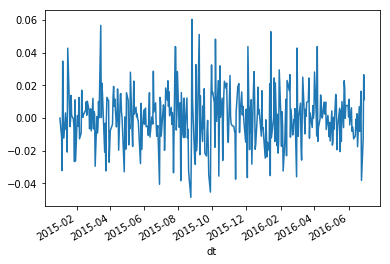

In [19]:
plt.figure()
ivv_daily_return_df.AMGN.plot()
#daily_return_df.AAMC.plot()
#daily_return_df.IBM.plot()

#daily_return_df.S1.plot()
#daily_return_df.S11.plot()
#daily_return_df.S2.plot()
#daily_return_df.S3.plot()


In [20]:
# plot distribution of returns
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

/Users/dustinvanstee/.virtualenvs/cssc_env36_tf18/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


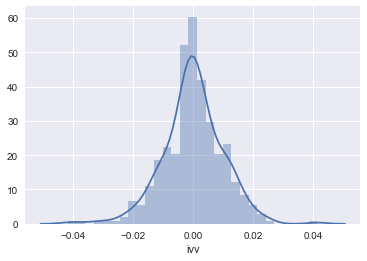

In [21]:
#sns.distplot(ivv_daily_return_df.AMGN)
sns.distplot(ivv_idx_df.ivv)



In [22]:
ivv_daily_return_df.describe()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,...,WBA,WDC,WEC,WFC,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,...,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000
mean,0.000312,-0.001485,0.000209,-0.000248,0.000031,-0.000343,0.003485,-0.000288,0.000703,0.000838,0.000178,-0.000448,0.000252,-0.000834,-0.000088,0.000423,0.000383,-0.000169,0.000988,0.000433,-0.000087,-0.000134,0.000457,0.000700,0.000022,...,0.000378,-0.001986,0.000572,-0.000310,-0.000252,-0.000058,0.000645,-0.000930,-0.000360,-0.001140,0.000251,-0.000446,-0.000655,0.000600,0.000580,-0.000102,0.000245,0.000089,0.000533,-0.000875,0.000446,0.000539,0.000231,-0.000131,0.000387
std,0.014822,0.023769,0.018270,0.016849,0.020039,0.012290,0.036070,0.015147,0.013595,0.016120,0.018785,0.017157,0.012007,0.019303,0.020527,0.011888,0.011989,0.018792,0.017924,0.011638,0.021082,0.013890,0.013775,0.015198,0.010755,...,0.016594,0.026931,0.012102,0.013787,0.019076,0.009570,0.009795,0.047254,0.013612,0.020925,0.015676,0.015230,0.035292,0.025895,0.011285,0.012289,0.016369,0.014125,0.013026,0.019504,0.012868,0.018921,0.012746,0.019932,0.017650
min,-0.054841,-0.108144,-0.154261,-0.065707,-0.103288,-0.074623,-0.285859,-0.092908,-0.062737,-0.082909,-0.078109,-0.087422,-0.042075,-0.193679,-0.084998,-0.049634,-0.052842,-0.086876,-0.065226,-0.049155,-0.147721,-0.072930,-0.067288,-0.134135,-0.046468,...,-0.107293,-0.118311,-0.049318,-0.050398,-0.090772,-0.083353,-0.049362,-0.348131,-0.100405,-0.149179,-0.068661,-0.067988,-0.166386,-0.103947,-0.049255,-0.087005,-0.087012,-0.047276,-0.045320,-0.133393,-0.062237,-0.188324,-0.047685,-0.101918,-0.122066
25%,-0.008498,-0.013335,-0.006843,-0.008452,-0.010587,-0.006214,-0.012381,-0.006728,-0.006888,-0.007667,-0.008655,-0.009112,-0.005841,-0.008675,-0.010660,-0.005971,-0.005770,-0.011946,-0.008988,-0.005858,-0.011690,-0.007887,-0.007146,-0.006789,-0.005921,...,-0.008346,-0.016169,-0.005441,-0.007342,-0.009871,0.000000,-0.004294,-0.017600,-0.006708,-0.006342,-0.008427,-0.008591,-0.019247,-0.015106,-0.005581,-0.006301,-0.008652,-0.007676,-0.007607,-0.010464,-0.007047,-0.007232,-0.007311,-0.011532,-0.009151
50%,0.000683,0.000243,0.000512,-0.000152,0.000571,0.000658,0.001242,0.000000,0.000877,0.001341,-0.000563,0.000565,0.000345,0.000704,0.000000,0.000833,0.001302,0.000757,0.001848,0.000941,-0.000979,0.000249,0.001471,0.001166,0.000323,...,-0.000299,-0.000416,0.000805,-0.000358,-0.000487,0.000000,0.000941,0.000000,-0.000139,0.000000,-0.000485,0.000000,-0.003469,-0.000142,0.001143,0.000584,0.000443,-0.000196,0.000874,0.000000,-0.000115,0.000209,0.000239,0.000000,0.000000
75%,0.009996,0.012011,0.008228,0.008784,0.010015,0.006166,0.019015,0.008399,0.007474,0.009946,0.008701,0.008856,0.007001,0.008888,0.010030,0.008127,0.007802,0.011013,0.011593,0.006964,0.011371,0.007268,0.008726,0.008987,0.005768,...,0.009419,0.012704,0.008896,0.007704,0.010319,0.000000,0.006240,0.016552,0.006589,0.004060,0.008914,0.007430,0.015290,0.016915,0.008638,0.006313,0.008919,0.007237,0.008350,0.010240,0.008589,0.009652,0.007463,0.011964,0.008937
max,0.042647,0.069096,0.111417,0.057355,0.100739,0.041760,0.292778,0.042617,0.067566,0.054543,0.101462,0.054821,0.058215,0.067263,0.097873,0.032939,0.029517,0.057490,0.046229,0.035456,0.078183,0.049089,0.034417,0.075905,0.038631,...,0.063478,0.144587,0.027639,0.047609,0.073100,0.036684,0.051667,0.343865,0.095804,0.114692,0.064143,0.051770,0

In [23]:
## Now lets flip this analysis on its head !!!
ivv_tp_df = ivv_daily_return_df.transpose()
ivv_tp_df.head()
ivv_tp_cvdf = ivv_daily_return_cvdf.transpose()

### Phase 1 : Encode
### Build an auto-encoder


In [24]:
num_tspoints = len(ivv_tp_df.columns) # Use 488 stocks as features
network_experiments = []
network_experiments.append( [100,25,5,25,100]) # Auto-encoder layers
#encoding_dims = [250,50,25,50,250] # Auto-encoder layers
#encoding_dims = [250,125,250] # Auto-encoder layers
#encoding_dims = [250] # Auto-encoder layers
#encoding_dims = [50] # Auto-encoder layers
#network_experiments.append( [100,20,100]) # Auto-encoder layers

#TODO : add geometric mean as experiment
#TODO : add experiment for batch size
#TODO : clustering using the encoding
#network_experiments = [[100,20,100],[50],[250,125,250]]
regularization = [0.0001] # , 0.000001, 0.0001, 0.01, 1
global_recon_error = 9999

# connect all layers
for encoding_dims in network_experiments:
    print("Working on " + str(encoding_dims))
    for r in regularization :
        input_layer = Input(shape=(num_tspoints, ))
        layer = []
        layer.append(input_layer)
        #encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
        for l in range(len(encoding_dims)) :
            layer.append (Dense(encoding_dims[l], activation='relu', kernel_regularizer=regularizers.l2(r))(layer[l]) )
        
        # see 'Stacked Auto-Encoders' in paper
        decoded = Dense(num_tspoints, activation= 'linear', kernel_regularizer=regularizers.l2(r))(layer[-1]) 
        
        
        # construct and compile AE model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='sgd', loss='mean_squared_error')
        
        # train autoencoder
        
        ae_scaler = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
        ae_scaler.fit(ivv_tp_df)
        x = ae_scaler.transform(ivv_tp_df)  
        
        #data = stock['calibrate']['net']
        fit_err = autoencoder.fit(x, x, shuffle=False, epochs=500, batch_size = 10,verbose=True)
        loss = fit_err.history['loss'][-1]
        
        # dont use cross val data for now .. use training tsk tsk
        xcv = ae_scaler.transform(ivv_tp_df)  
        recon_error = np.linalg.norm(autoencoder.predict(xcv)-xcv)
        
        # Select Model that works best on CV data
        if(recon_error < global_recon_error) :
            print("New Model found! ")
            print("Best recon error = " + str(recon_error))
            print("best_regularization= " + str(r))
            print("best_encoding_dims= " + str(encoding_dims))
            global_recon_error = recon_error
            best_regularization = r
            best_encoding_dims = encoding_dims
            best_autoencoder = autoencoder

print("Best model settings : ")
print("Regularization = " + str(best_regularization))
print("Network = " + str(best_encoding_dims))

#autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
#reconstruct = autoencoder.predict(data)

Working on [100, 25, 5, 25, 100]
Epoch 1/500
487/487 [==============================] - 0s 727us/step - loss: 1.0608
Epoch 2/500
487/487 [==============================] - 0s 154us/step - loss: 1.0535
Epoch 3/500
487/487 [==============================] - 0s 159us/step - loss: 1.0495
Epoch 4/500
487/487 [==============================] - 0s 160us/step - loss: 1.0470
Epoch 5/500
487/487 [==============================] - 0s 158us/step - loss: 1.0453
Epoch 6/500
487/487 [==============================] - 0s 156us/step - loss: 1.0441
Epoch 7/500
487/487 [==============================] - 0s 155us/step - loss: 1.0431
Epoch 8/500
487/487 [==============================] - 0s 159us/step - loss: 1.0424
Epoch 9/500
487/487 [==============================] - 0s 157us/step - loss: 1.0418
Epoch 10/500
487/487 [==============================] - 0s 159us/step - loss: 1.0413
Epoch 11/500
487/487 [==============================] - 0s 147us/step - loss: 1.0409
Epoch 12/500
487/487 [===================

487/487 [==============================] - 0s 141us/step - loss: 1.0345
Epoch 98/500
487/487 [==============================] - 0s 114us/step - loss: 1.0344
Epoch 99/500
487/487 [==============================] - 0s 113us/step - loss: 1.0343
Epoch 100/500
487/487 [==============================] - 0s 127us/step - loss: 1.0343
Epoch 101/500
487/487 [==============================] - 0s 154us/step - loss: 1.0342
Epoch 102/500
487/487 [==============================] - 0s 125us/step - loss: 1.0341
Epoch 103/500
487/487 [==============================] - 0s 136us/step - loss: 1.0340
Epoch 104/500
487/487 [==============================] - 0s 171us/step - loss: 1.0339
Epoch 105/500
487/487 [==============================] - 0s 149us/step - loss: 1.0339
Epoch 106/500
487/487 [==============================] - 0s 133us/step - loss: 1.0338
Epoch 107/500
487/487 [==============================] - 0s 110us/step - loss: 1.0337
Epoch 108/500
487/487 [==============================] - 0s 117us/step

487/487 [==============================] - 0s 131us/step - loss: 1.0130
Epoch 193/500
487/487 [==============================] - 0s 134us/step - loss: 1.0125
Epoch 194/500
487/487 [==============================] - 0s 176us/step - loss: 1.0120
Epoch 195/500
487/487 [==============================] - 0s 154us/step - loss: 1.0115
Epoch 196/500
487/487 [==============================] - 0s 167us/step - loss: 1.0110
Epoch 197/500
487/487 [==============================] - 0s 188us/step - loss: 1.0105
Epoch 198/500
487/487 [==============================] - 0s 162us/step - loss: 1.0100
Epoch 199/500
487/487 [==============================] - 0s 161us/step - loss: 1.0094
Epoch 200/500
487/487 [==============================] - 0s 123us/step - loss: 1.0088
Epoch 201/500
487/487 [==============================] - 0s 111us/step - loss: 1.0082
Epoch 202/500
487/487 [==============================] - 0s 150us/step - loss: 1.0076
Epoch 203/500
487/487 [==============================] - 0s 136us/st

487/487 [==============================] - 0s 134us/step - loss: 0.9299
Epoch 288/500
487/487 [==============================] - 0s 157us/step - loss: 0.9296
Epoch 289/500
487/487 [==============================] - 0s 164us/step - loss: 0.9292
Epoch 290/500
487/487 [==============================] - 0s 163us/step - loss: 0.9288
Epoch 291/500
487/487 [==============================] - 0s 140us/step - loss: 0.9284
Epoch 292/500
487/487 [==============================] - 0s 164us/step - loss: 0.9281
Epoch 293/500
487/487 [==============================] - 0s 158us/step - loss: 0.9277
Epoch 294/500
487/487 [==============================] - 0s 136us/step - loss: 0.9274
Epoch 295/500
487/487 [==============================] - 0s 129us/step - loss: 0.9271
Epoch 296/500
487/487 [==============================] - 0s 127us/step - loss: 0.9267
Epoch 297/500
487/487 [==============================] - 0s 141us/step - loss: 0.9264
Epoch 298/500
487/487 [==============================] - 0s 123us/st

487/487 [==============================] - 0s 135us/step - loss: 0.9076
Epoch 383/500
487/487 [==============================] - 0s 152us/step - loss: 0.9074
Epoch 384/500
487/487 [==============================] - 0s 132us/step - loss: 0.9072
Epoch 385/500
487/487 [==============================] - 0s 129us/step - loss: 0.9070
Epoch 386/500
487/487 [==============================] - 0s 163us/step - loss: 0.9068
Epoch 387/500
487/487 [==============================] - 0s 144us/step - loss: 0.9067
Epoch 388/500
487/487 [==============================] - 0s 123us/step - loss: 0.9065
Epoch 389/500
487/487 [==============================] - 0s 138us/step - loss: 0.9063
Epoch 390/500
487/487 [==============================] - 0s 119us/step - loss: 0.9061
Epoch 391/500
487/487 [==============================] - 0s 131us/step - loss: 0.9059
Epoch 392/500
487/487 [==============================] - 0s 146us/step - loss: 0.9057
Epoch 393/500
487/487 [==============================] - 0s 125us/st

487/487 [==============================] - 0s 114us/step - loss: 0.8874
Epoch 478/500
487/487 [==============================] - 0s 145us/step - loss: 0.8872
Epoch 479/500
487/487 [==============================] - 0s 145us/step - loss: 0.8869
Epoch 480/500
487/487 [==============================] - 0s 135us/step - loss: 0.8867
Epoch 481/500
487/487 [==============================] - 0s 113us/step - loss: 0.8864
Epoch 482/500
487/487 [==============================] - 0s 134us/step - loss: 0.8862
Epoch 483/500
487/487 [==============================] - 0s 113us/step - loss: 0.8859
Epoch 484/500
487/487 [==============================] - 0s 124us/step - loss: 0.8857
Epoch 485/500
487/487 [==============================] - 0s 115us/step - loss: 0.8854
Epoch 486/500
487/487 [==============================] - 0s 113us/step - loss: 0.8851
Epoch 487/500
487/487 [==============================] - 0s 118us/step - loss: 0.8849
Epoch 488/500
487/487 [==============================] - 0s 114us/st

In [26]:
best_autoencoder.summary()
print(best_encoding_dims)
print(best_regularization)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               37700     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                150       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_6 (Dense)              (None, 376)               37976     
Total para

### Cluster Based on the embedded layer ...

In [27]:
best_autoencoder.layers

In [28]:
outputs = [layer.output for layer in best_autoencoder.layers]

In [29]:
outputs[4]

<tf.Tensor 'dense_4/Relu:0' shape=(?, 25) dtype=float32>

In [32]:
embedded_ts = Model(input=best_autoencoder.input, outputs=best_autoencoder.get_layer('dense_3').output)

/Users/dustinvanstee/.virtualenvs/cssc_env36_tf18/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [33]:
embedded_ts.summary()
encode = embedded_ts.predict(x=ivv_tp_df)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               37700     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
Total params: 40,355
Trainable params: 40,355
Non-trainable params: 0
_________________________________________________________________


In [34]:
encode[0]

array([0.07574187, 0.        , 0.30188707, 0.20145926, 0.09735569],
      dtype=float32)

In [35]:
ticker_encode = pd.DataFrame(data=encode, index=ivv_tp_df.index)
ticker_encode

,0,1,2,3,4
ticker,,,,,
A,0.075742,0.000000,0.301887,0.201459,0.097356
AAL,0.133998,0.012164,0.361491,0.151112,0.128356
AAP,0.076257,0.000000,0.247921,0.141775,0.091637
AAPL,0.049780,0.000000,0.293567,0.184647,0.082663
ABBV,0.094442,0.000000,0.285114,0.134207,0.085984
ABC,0.081090,0.000000,0.234181,0.115578,0.093519
ABMD,0.108902,0.052263,0.473487,0.204497,0.075925
ABT,0.079405,0.000000,0.269582,0.157201,0.114947
ACN,0.059720,0.000000,0.246879,0.160391,0.077787


In [58]:
from sklearn.cluster import KMeans
import numpy as np
X = ticker_encode
num_clusters=11
kmeans = KMeans(n_clusters=num_clusters, random_state=1).fit(ticker_encode)
kmeans.labels_

array([10,  6,  9, 10,  9,  9,  6,  9,  3,  9, 10,  4,  3, 10, 10,  5,  5,
        4,  9,  3,  6, 10,  2,  3,  3, 10,  4, 10,  6,  3,  9,  6, 10,  7,
        4,  7,  9,  0,  2,  9,  3,  9,  3, 10,  8,  8,  3,  3,  2,  1,  9,
        2,  7,  9,  5,  9, 10,  2, 10,  0,  9,  0,  3,  3, 10,  6,  0, 10,
        3,  9,  9,  7,  2,  0,  3,  2,  9,  4,  3,  2,  4,  2,  9, 10,  6,
        9,  1,  0,  2,  2,  9,  9,  3,  2,  5,  7,  2,  9,  2,  4,  5,  9,
        2,  0,  1,  3,  2,  1,  2,  3,  5,  6,  4,  4,  9,  3,  9, 10,  2,
        1,  1,  5,  6,  3,  4,  2,  9, 10,  3,  3,  4,  4, 10,  5,  2,  4,
        5,  2,  2,  5,  5,  3,  8,  9,  9,  4,  5,  9,  5,  2,  4,  4,  1,
        9,  2,  1,  5,  9,  2,  7,  4,  5, 10,  6,  2,  3,  9,  5,  4,  3,
        9,  3,  8, 10,  5, 10,  3,  3,  0,  2,  3,  1,  1,  1,  3,  3,  5,
        1,  3,  3,  5,  9,  5,  3, 10,  9,  9,  3, 10,  2,  4,  0, 10,  3,
        1,  3,  0,  9,  9,  5,  9,  1, 10,  3, 10,  9,  3,  8,  3,  4,  9,
        2, 10,  2,  4,  5

In [59]:
ticker_encode["cluster"] = kmeans.labels_

In [60]:
# Join with real sectors ...
sectors_df[sectors_df["GICSSector"] == 'Industrials']
sectors_df["Tickersymbol"]

0        MMM
1        ABT
2       ABBV
3        ACN
4       ATVI
5        AYI
6       ADBE
7        AMD
8        AAP
9        AES
10       AET
11       AMG
12       AFL
13         A
14       APD
15      AKAM
16       ALK
17       ALB
18       ARE
19      ALXN
20      ALGN
21      ALLE
22       AGN
23       ADS
24       LNT
25       ALL
26     GOOGL
27      GOOG
28        MO
29      AMZN
30       AEE
31       AAL
32       AEP
33       AXP
34       AIG
35       AMT
36       AWK
37       AMP
38       ABC
39       AME
40      AMGN
41       APH
42       APC
43       ADI
44      ANDV
45      ANSS
46      ANTM
47       AON
48       AOS
49       APA
50       AIV
51      AAPL
52      AMAT
53      APTV
54       ADM
55      ARNC
56       AJG
57       AIZ
58         T
59      ADSK
60       ADP
61       AZO
62       AVB
63       AVY
64      BHGE
65       BLL
66       BAC
67        BK
68       BAX
69       BBT
70       BDX
71     BRK.B
72       BBY
73      BIIB
74       BLK
75       HRB
76        BA

In [61]:
join_tickers = ticker_encode.join(sectors_df.set_index('Tickersymbol'), how="inner")
join_tickers.head(3)

,0,1,2,3,4,cluster,Security,SECfilings,GICSSector,GICSSubIndustry,AddressofHeadquarters,Datefirstadded,CIK
A,0.075742,0.000000,0.301887,0.201459,0.097356,10,Agilent Technologies Inc,reports,Health Care,Health Care Equipment,"Santa Clara, California",6/5/00,1090872
AAL,0.133998,0.012164,0.361491,0.151112,0.128356,6,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",3/23/15,6201
AAP,0.076257,0.000000,0.247921,0.141775,0.091637,9,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",7/9/15,1158449


In [62]:
# Print Per Sector Report
for i,s in enumerate(join_tickers['GICSSector'].unique()) :
    print("#################### Sector " + s + ":" +  str(i) + " ##############")
    print("cluster,count")
    print(join_tickers[join_tickers["GICSSector"] == s]['cluster'].value_counts())

# Print Per Cluster Report
for i in range(num_clusters) :
    print("#################### Cluster " + str(i) + " ##############")
    print(join_tickers[join_tickers["cluster"] == i]['GICSSector'].value_counts())

  

#################### Sector Health Care:0 ##############
cluster,count
9     27
6     12
3      9
10     7
2      5
Name: cluster, dtype: int64
#################### Sector Industrials:1 ##############
cluster,count
3     19
4     16
10    10
2      8
6      5
9      3
1      3
7      1
Name: cluster, dtype: int64
#################### Sector Consumer Discretionary:2 ##############
cluster,count
2     20
9     16
3     16
10    13
4      8
7      1
6      1
1      1
0      1
Name: cluster, dtype: int64
#################### Sector Information Technology:3 ##############
cluster,count
10    23
3     17
9     14
4      6
7      5
6      2
1      2
0      1
Name: cluster, dtype: int64
#################### Sector Consumer Staples:4 ##############
cluster,count
2    17
5    11
3     3
9     1
4     1
Name: cluster, dtype: int64
#################### Sector Utilities:5 ##############
cluster,count
5    22
2     4
4     1
1     1
Name: cluster, dtype: int64
#################### Sector Financials:

In [63]:
join_tickers[join_tickers["cluster"] == 1].index

Index(['ARNC', 'CF', 'COG', 'COP', 'CVX', 'CXO', 'EOG', 'EQT', 'FLR', 'FLS',
       'FMC', 'FTI', 'HAL', 'HES', 'KMI', 'LYB', 'MOS', 'NBL', 'NFX', 'NOV',
       'NRG', 'OKE', 'OXY', 'PXD', 'RRC', 'SLB', 'STX', 'WDC', 'WYNN', 'XEC'],
      dtype='object')

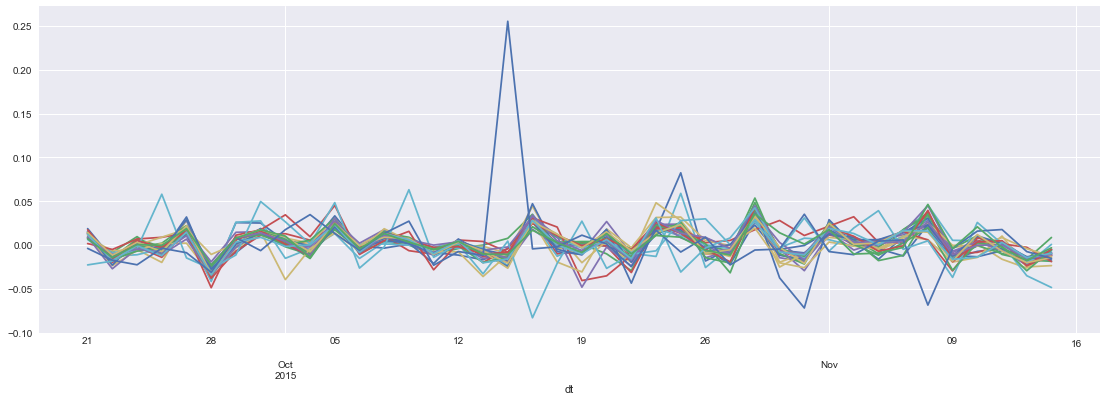

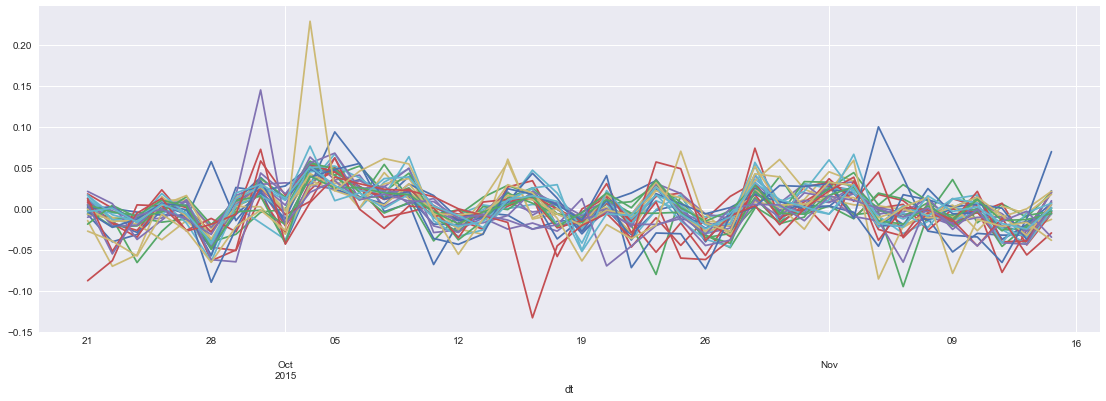

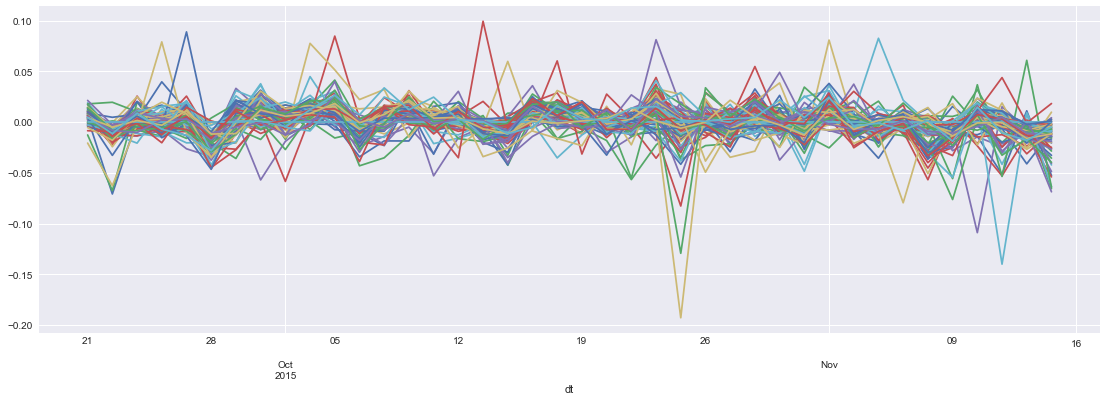

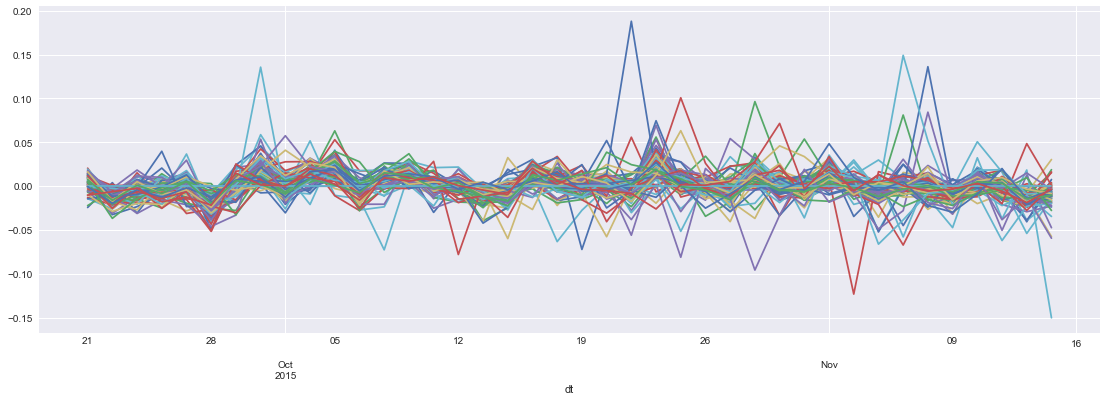

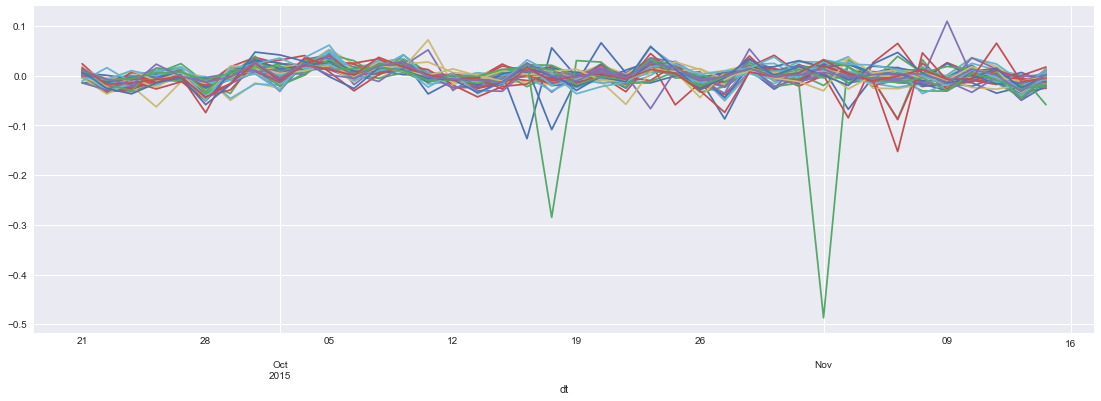

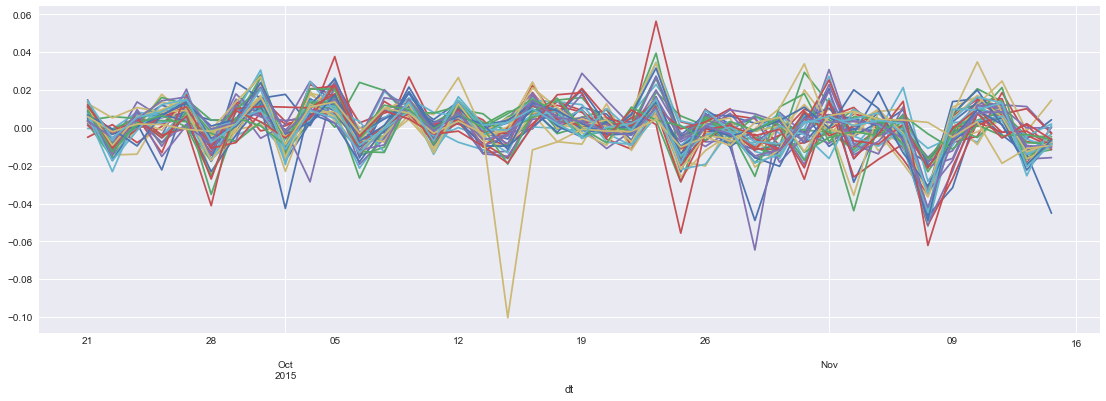

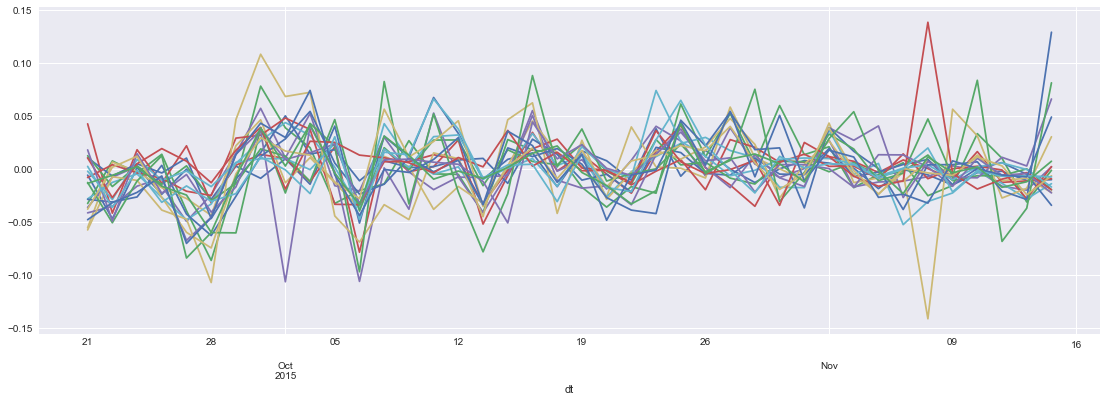

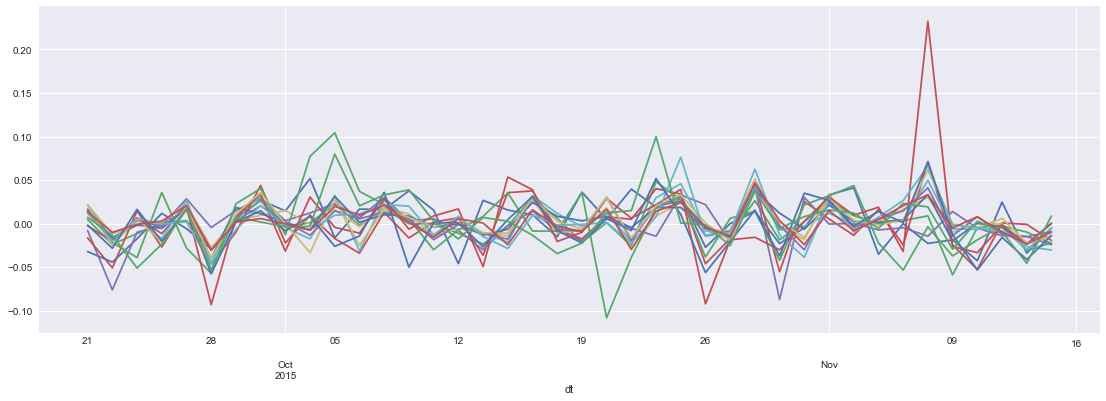

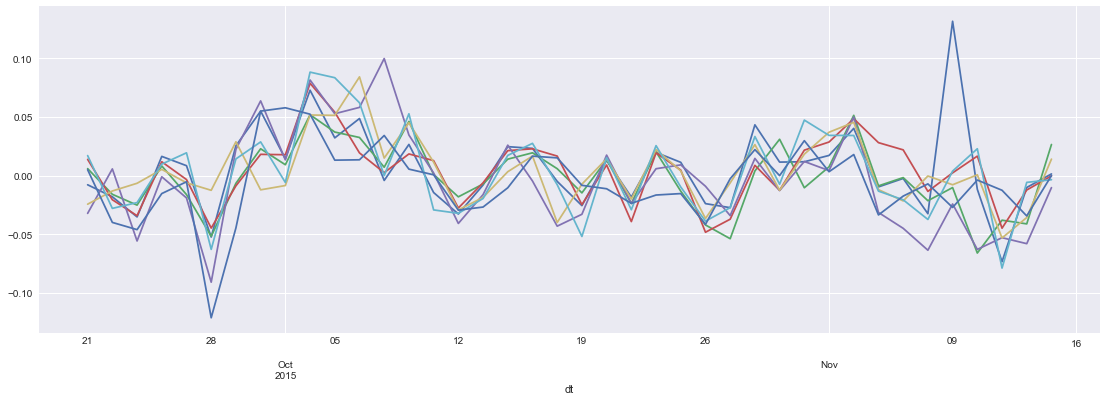

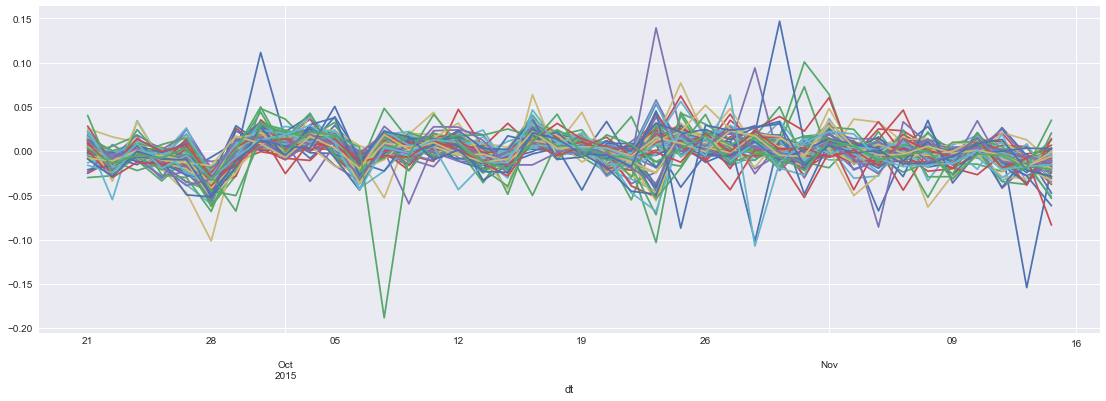

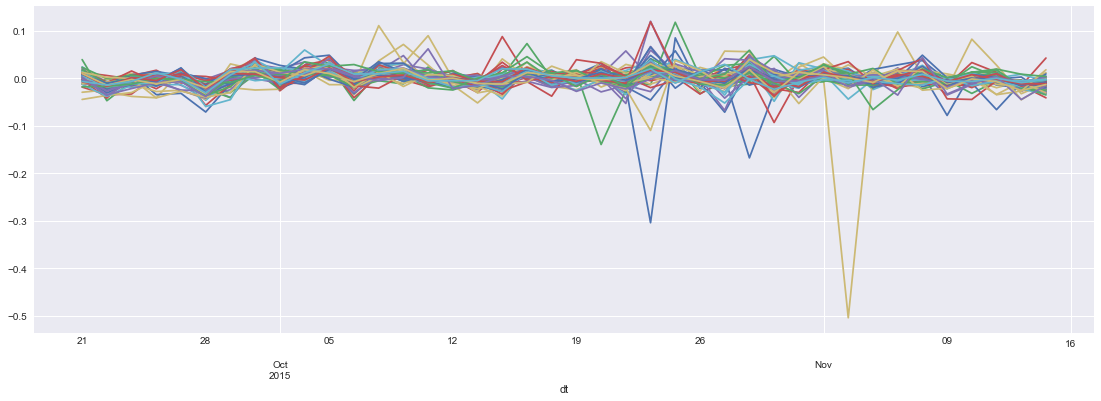

In [67]:

for j in range(num_clusters) :
    cluster_tickers = join_tickers[join_tickers["cluster"] == j].index.tolist()
    plt.figure()

    for i in cluster_tickers :
        ivv_daily_return_df[i].iloc[180:220].plot(figsize=(19,6))
    


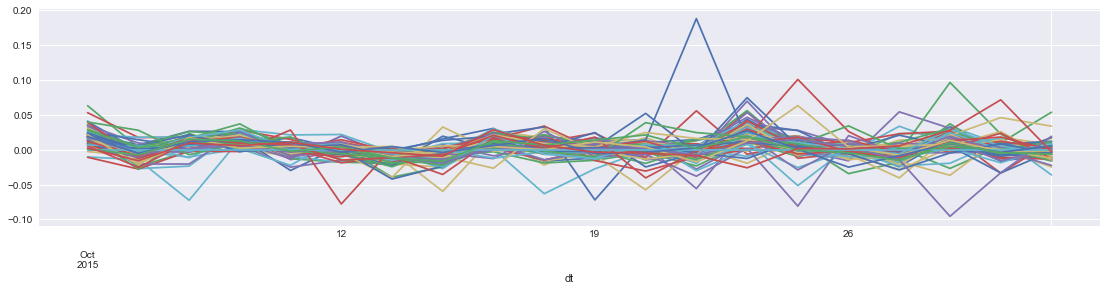

In [65]:
cluster_tickers = join_tickers[join_tickers["cluster"] == 3].index.tolist()
for i in cluster_tickers :
    ivv_daily_return_df[i].iloc[190:210].plot(figsize=(19,4))
    


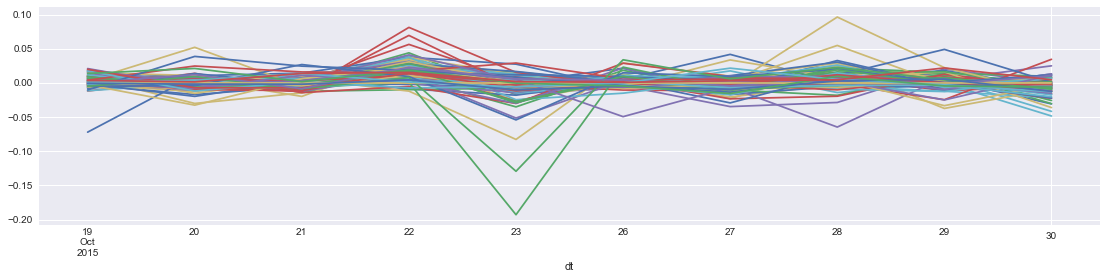

In [148]:
cluster_tickers = join_tickers[join_tickers["cluster"] == 4].index.tolist()
for i in cluster_tickers :
    ivv_daily_return_df[i].iloc[200:210].plot(figsize=(19,4))
 

In [128]:
# test/reconstruct market information matrix
ae_scaler = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
ae_scaler.fit(ivv_daily_return_df)
x = ae_scaler.transform(ivv_daily_return_cvdf)  

reconstruct = best_autoencoder.predict(x)

In [129]:
x[1:20,0:2]

array([[ 1.09070394, -0.78205361],
       [-0.09702287,  1.62285246],
       [ 1.59101877,  0.97962531],
       [-0.13989774,  1.63324064],
       [ 1.66038091,  4.79453485],
       [-0.19529098, -0.19269975],
       [ 0.54662669,  1.81126647],
       [-0.20872078,  0.07429039],
       [ 0.16711028,  0.22688297],
       [ 0.23876225,  0.03916391],
       [ 0.02207229, -0.04274226],
       [-0.50966202, -1.06337159],
       [-0.15134291,  1.74960481],
       [-0.65920359, -0.5862901 ],
       [ 1.16488824,  0.94512288],
       [ 0.42498676, -0.34086739],
       [ 0.33629428,  0.22547569],
       [ 0.83208644, -0.91124528],
       [-0.35807181,  0.18121994]])

In [130]:
reconstruct[1:20,0:2]

array([[ 0.51072574,  0.38329306],
       [ 0.15214342,  0.09715614],
       [ 1.4098104 ,  0.917252  ],
       [ 0.12335544,  0.10373759],
       [ 0.7447094 ,  0.46381208],
       [-0.11258691, -0.03625194],
       [ 0.5264917 ,  0.31631216],
       [-0.09642379, -0.19611834],
       [ 0.13163045, -0.18326889],
       [-0.22896329,  0.11987764],
       [ 0.54243845,  0.25965238],
       [-0.2781184 , -0.29710773],
       [ 0.43591765,  0.6456406 ],
       [-0.30196014, -0.16876608],
       [ 0.42959884,  0.18714532],
       [-0.2826817 , -0.22632518],
       [ 0.24831483,  0.23750888],
       [-0.26450998, -0.14963432],
       [-0.26283127,  0.15497656]], dtype=float32)

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [131]:
communal_information = []

for i in range(0,num_stock):
    diff = np.linalg.norm((x[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()


stock #, 2-norm, stock name


In [132]:
communal_information

[7.645362810129616,
 9.15726641660244,
 10.986344070143318,
 7.973314183970189,
 7.682721302788641,
 18.234785554493875,
 5.483371943474162,
 7.427998122988413,
 8.979324604528456,
 5.942202037939679,
 6.612528650607213,
 9.149710247767812,
 7.286056864988115,
 9.234185123179886,
 8.794809601223537,
 5.414634432929466,
 5.507681884637162,
 7.633237702423322,
 7.889700542081985,
 6.31219293702508,
 8.832441165823585,
 7.126757233872345,
 8.50093031452553,
 8.558683926979482,
 6.741322991074961,
 10.473202988585578,
 6.757315119038521,
 6.423035193152729,
 8.796629812100859,
 5.472401721501032,
 6.929439596737348,
 12.251490798190012,
 8.100009819525656,
 9.239457794932655,
 8.145659619922032,
 6.733803150915657,
 8.768907819329888,
 8.438679325794153,
 9.148369756895198,
 6.569317319754708,
 7.654150060846563,
 10.005035107645437,
 7.494701115483647,
 31.302991697773713,
 6.046819937747623,
 6.960777756770837,
 7.114079806757591,
 5.777686136529589,
 9.407136412283636,
 71.9977366867455

In [133]:
ranking

array([320, 449, 360, 274, 207, 390, 198, 321, 392, 100,  78, 385, 447,
        73, 305, 336, 119, 243, 148, 406, 464, 476,  61, 423, 469, 156,
       363, 249, 445, 219, 145, 129, 397, 344,  15, 361, 391, 329, 234,
       221, 380,  29,   6,  16,  67,  59,  95,  60, 117, 318, 242, 172,
       193, 456, 485,  87, 195, 103, 140, 359, 348,  47, 401, 419, 146,
       159, 302, 196, 124, 342, 298,   9,  66, 102, 293,  93,  70, 357,
       137, 139, 121, 387, 222,  44, 142, 161,  92, 327, 229, 297, 369,
       367, 343, 120, 186, 283, 437, 307,  52, 395, 166,  19, 377, 443,
       273, 475, 189,  27,  58, 316, 204, 178, 112, 278, 187, 252, 435,
       176, 144, 309, 345, 338,  39, 481, 365,  86, 127, 261,  10, 486,
       170, 201, 393, 459, 227, 211,  35,  24, 448,  26, 264, 173, 358,
       217, 107, 478, 282, 434,  30, 354,  45, 267, 422, 313, 386, 410,
        96, 424, 355, 143, 182, 164, 257, 468, 206, 479, 280, 407, 233,
       289,  46, 269, 136, 235,  21, 260, 444, 353, 215, 210, 11

In [134]:
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], ivv_daily_return_df.iloc[:,stock_index].name) # print stock name from lowest different to highest

320 3.373463003117099 NI
449 3.714675571944794 V
360 3.805394057767927 PPG
274 3.9781511562927965 LNT
207 4.2951201801612 HBI
390 4.332824199696619 SBUX
198 4.447108482790226 GPN
321 4.462228679837602 NKE
392 4.53972482702907 SCHW
100 4.621930555762442 CMS
78 4.677989197681142 CB
385 4.678336927605319 ROST
447 4.690777260830631 USB
73 4.859760151168021 C
305 4.921099254451313 MS
336 4.92273296994005 OKE
119 4.944568727191372 CVX
243 4.951631106011045 IVZ
148 5.021875524781375 EIX
406 5.024256126180365 STI
464 5.059815296820605 WEC
476 5.128138999230587 XEL
61 5.145185141084586 BBT
423 5.161427880971221 TMK
469 5.234721254828468 WMB
156 5.240684833856288 ES
363 5.2407669541391515 PRU
249 5.287167730760329 JPM
445 5.320417758418076 UPS
219 5.339022046069599 HPQ
145 5.341819275165691 ECL
129 5.347345420511438 DIS
397 5.399150100267259 SLB
344 5.40262297220886 PCG
15 5.414634432929466 AEE
361 5.420963630697482 PPL
391 5.437048336518443 SCG
329 5.44474419352886 NTRS
234 5.445627596685278 IN

In [135]:
reconstruct[:,20]

array([ 0.00622734,  0.21383858, -0.14173655,  0.6493154 ,  0.02086075,
        0.16177301,  0.06758892,  0.38009325, -0.16074376,  0.11022907,
       -0.14485121,  0.44170034,  0.22027954,  0.12211567,  0.02873486,
        0.13714957, -0.16824721,  0.14116043, -0.0969955 , -0.0109245 ,
       -0.6328801 , -0.04837292,  0.15382068,  0.5222729 , -0.3277776 ,
        0.13605769, -0.51655096,  0.20675813,  0.19365999,  0.15007271,
       -0.49241564, -0.27623433, -0.00544144, -0.09378866,  0.12542754,
       -0.17442037, -0.63465434, -0.23561688, -0.12521599,  0.10409434,
       -0.04432326,  0.17554814,  0.01712197, -0.993609  ,  0.03883265,
       -0.04517298, -0.02974574, -1.2025349 ,  0.7747473 , -1.0883874 ,
       -0.31515595,  0.52976495,  0.01216143, -0.01099011,  0.05958597,
        0.69429874,  0.12463661, -0.09550957, -0.2904592 ,  0.2819391 ,
        0.07156613, -0.6646792 ,  0.35417268, -0.6062626 , -0.14995418,
       -0.17878293, -0.01699726, -0.16947493,  0.35250843, -1.22

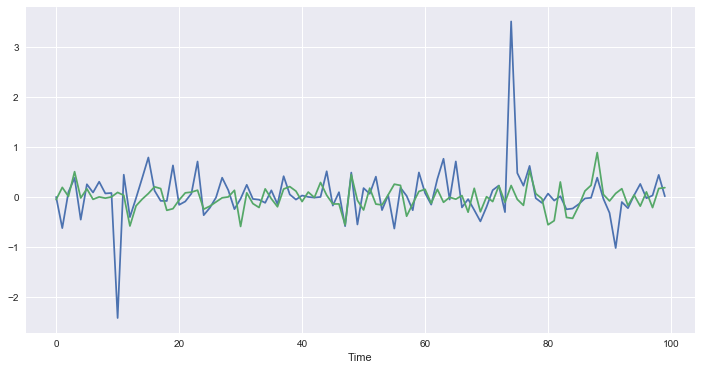

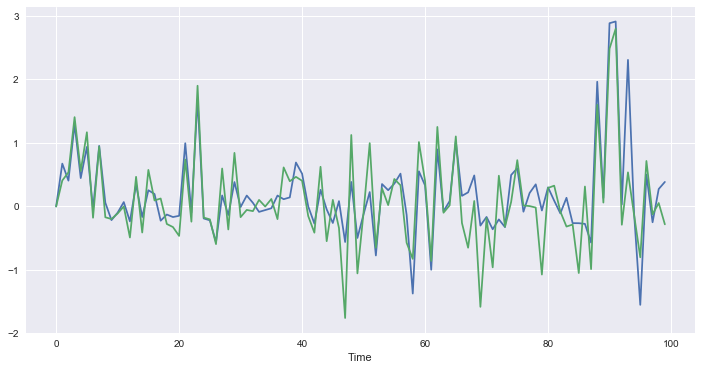

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# This function is used to plot time series date from multiple application instances 
# params : colname => time series column name
# params : df => dataframe to extract data from..


# build a list of unique instances ...


plt.figure(figsize=(12,6))

           
plt.plot(x[0:100,318])
plt.plot(reconstruct[0:100,318])

#plt.title(colname)
plt.xlabel("Time")
#plt.ylabel(ylabel)
#plt.legend(loc=2, labels =instance_list)
plt.show()

plt.figure(figsize=(12,6))

plt.plot(x[0:100,249])
plt.plot(reconstruct[0:100,249])

#plt.title(colname)
plt.xlabel("Time")
#plt.ylabel(ylabel)
#plt.legend(loc=2, labels =instance_list)
plt.show()

In [ ]:
#ivv_idx_df.ivv.iloc[:,]
#ibb_daily_return_df.iloc[:,[0,3]]

In [ ]:
#start_value = full_price_df[(full_price_df['ticker'] == 'ibb') & (full_price_df['date'] == '2017-01-03')]['close']
#full_price_df[(full_price_df['ticker'] == 'ibb') & (full_price_df['date'] == '2001-02-13')]


In [145]:
ivv_actual = get_stock_df(full_price_df, ['ivv'], INSAMPLE_START_DATE, INSAMPLE_END_DATE, mode='levels').values
# below is correct too, but ugly!
#ibb_actual = (ibb_idx_df['ibb'] + 1).cumprod()*start_value.values[0]


Empty DataFrame
Columns: []
Index: [ivv]


### Phase 2 Calibrate 

In [146]:
ivv_actual[0][0]

206.729996

In [147]:
ivv_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    print("stock_index = " + str(stock_index))
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.001))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = ivv_daily_return_df.iloc[:, stock_index]
    y = ivv_idx_df.ivv.iloc[:,].values
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    print(x)
    print(y)
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    print(deep_learner.get_weights())
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage ) + 1
    print(relative_percentage)
    
    # Rebuild the ivv index using start value
    # print(relative_percentage.cumprod() * start_value.values[0])
    ivv_predict['calibrate'+str(s)] = ivv_actual[0][0] * (relative_percentage.cumprod()) 
    
    total_2_norm_diff['calibrate'+str(s)] = np.linalg.norm((ivv_predict['calibrate'+str(s)] - ivv_actual))

stock_index = [320 449 360 274 207 390 198 321 392 100 323 288 483 331  69   5 403  75
 436  43 299  88 228  49 162]
[[ 0.00787229  0.03613057  0.05095633 ... -0.03411331  0.03921563
   0.01417558]
 [-0.32864008 -0.49772564 -0.81854754 ...  0.33219511 -2.03867832
  -0.66561121]
 [-0.32584049 -0.11970939 -0.03196519 ... -0.99235739  0.30293811
   0.42368602]
 ...
 [ 0.10946419 -0.51492132 -1.27407852 ... -1.17334482 -1.03141889
  -1.17772804]
 [ 0.22158414  0.63630512  0.68938397 ...  1.65865694  0.94572541
   0.26931704]
 [ 0.3093132   0.54454446  0.69761524 ...  1.16101134 -0.84494717
   0.08454397]]
[ 0.00000000e+00 -1.75590871e-02 -9.01034932e-03  1.23713964e-02
  1.78641494e-02 -8.43780159e-03 -7.58569436e-03 -2.59688378e-03
 -6.04242490e-03 -9.39064390e-03  1.28224671e-02  2.46305419e-03
  4.91400491e-03  1.46699267e-02 -5.34940241e-03  2.66487234e-03
 -1.34338358e-02 -1.29310342e-02  9.57717825e-03 -1.26812585e-02
  1.21471751e-02  1.42147412e-02 -3.54023284e-03  1.04637854e-02
 

376/376 [==============================] - 0s 194us/step - loss: 0.0058
Epoch 115/500
376/376 [==============================] - 0s 218us/step - loss: 0.0058
Epoch 116/500
376/376 [==============================] - 0s 202us/step - loss: 0.0058
Epoch 117/500
376/376 [==============================] - 0s 293us/step - loss: 0.0058
Epoch 118/500
376/376 [==============================] - 0s 254us/step - loss: 0.0058
Epoch 119/500
376/376 [==============================] - 0s 186us/step - loss: 0.0058
Epoch 120/500
376/376 [==============================] - 0s 287us/step - loss: 0.0058
Epoch 121/500
376/376 [==============================] - 0s 236us/step - loss: 0.0057
Epoch 122/500
376/376 [==============================] - 0s 286us/step - loss: 0.0057
Epoch 123/500
376/376 [==============================] - 0s 263us/step - loss: 0.0057
Epoch 124/500
376/376 [==============================] - 0s 209us/step - loss: 0.0057
Epoch 125/500
376/376 [==============================] - 0s 215us/st

376/376 [==============================] - 0s 247us/step - loss: 0.0043
Epoch 305/500
376/376 [==============================] - 0s 264us/step - loss: 0.0043
Epoch 306/500
376/376 [==============================] - 0s 315us/step - loss: 0.0043
Epoch 307/500
376/376 [==============================] - 0s 290us/step - loss: 0.0043
Epoch 308/500
376/376 [==============================] - 0s 255us/step - loss: 0.0043
Epoch 309/500
376/376 [==============================] - 0s 229us/step - loss: 0.0042
Epoch 310/500
376/376 [==============================] - 0s 211us/step - loss: 0.0042
Epoch 311/500
376/376 [==============================] - 0s 219us/step - loss: 0.0042
Epoch 312/500
376/376 [==============================] - 0s 206us/step - loss: 0.0042
Epoch 313/500
376/376 [==============================] - 0s 241us/step - loss: 0.0042
Epoch 314/500
376/376 [==============================] - 0s 204us/step - loss: 0.0042
Epoch 315/500
376/376 [==============================] - 0s 233us/st

376/376 [==============================] - 0s 178us/step - loss: 0.0032
Epoch 495/500
376/376 [==============================] - 0s 244us/step - loss: 0.0032
Epoch 496/500
376/376 [==============================] - 0s 256us/step - loss: 0.0032
Epoch 497/500
376/376 [==============================] - 0s 328us/step - loss: 0.0032
Epoch 498/500
376/376 [==============================] - 0s 288us/step - loss: 0.0032
Epoch 499/500
376/376 [==============================] - 0s 291us/step - loss: 0.0032
Epoch 500/500
376/376 [==============================] - 0s 240us/step - loss: 0.0032
[array([[-0.20756012,  0.23538806,  0.21955429,  0.22715671,  0.19365239],
       [-0.03101491, -0.07513777, -0.14527462,  0.03166947,  0.03918879],
       [ 0.16083741,  0.23076552,  0.19655903,  0.1692961 ,  0.2289561 ],
       [ 0.06346987, -0.00241437,  0.05459599,  0.02057934,  0.18000413],
       [ 0.2861143 ,  0.21333712, -0.16782255, -0.18924299, -0.08904538],
       [ 0.2670522 ,  0.17206107,  0.2897

376/376 [==============================] - 2s 6ms/step - loss: 0.4715
Epoch 2/500
376/376 [==============================] - 0s 343us/step - loss: 0.1539
Epoch 3/500
376/376 [==============================] - 0s 306us/step - loss: 0.0938
Epoch 4/500
376/376 [==============================] - 0s 367us/step - loss: 0.0662
Epoch 5/500
376/376 [==============================] - 0s 318us/step - loss: 0.0504
Epoch 6/500
376/376 [==============================] - 0s 228us/step - loss: 0.0404
Epoch 7/500
376/376 [==============================] - 0s 366us/step - loss: 0.0336
Epoch 8/500
376/376 [==============================] - 0s 442us/step - loss: 0.0287
Epoch 9/500
376/376 [==============================] - 0s 336us/step - loss: 0.0251
Epoch 10/500
376/376 [==============================] - 0s 253us/step - loss: 0.0223
Epoch 11/500
376/376 [==============================] - 0s 253us/step - loss: 0.0201
Epoch 12/500
376/376 [==============================] - 0s 360us/step - loss: 0.0183
Epo

376/376 [==============================] - 0s 233us/step - loss: 0.0053
Epoch 193/500
376/376 [==============================] - 0s 304us/step - loss: 0.0053
Epoch 194/500
376/376 [==============================] - 0s 260us/step - loss: 0.0053
Epoch 195/500
376/376 [==============================] - 0s 267us/step - loss: 0.0053
Epoch 196/500
376/376 [==============================] - 0s 259us/step - loss: 0.0053
Epoch 197/500
376/376 [==============================] - 0s 215us/step - loss: 0.0053
Epoch 198/500
376/376 [==============================] - 0s 230us/step - loss: 0.0053
Epoch 199/500
376/376 [==============================] - 0s 234us/step - loss: 0.0053
Epoch 200/500
376/376 [==============================] - 0s 222us/step - loss: 0.0052
Epoch 201/500
376/376 [==============================] - 0s 189us/step - loss: 0.0052
Epoch 202/500
376/376 [==============================] - 0s 199us/step - loss: 0.0052
Epoch 203/500
376/376 [==============================] - 0s 218us/st

376/376 [==============================] - 0s 227us/step - loss: 0.0040
Epoch 383/500
376/376 [==============================] - 0s 244us/step - loss: 0.0040
Epoch 384/500
376/376 [==============================] - 0s 253us/step - loss: 0.0040
Epoch 385/500
376/376 [==============================] - 0s 259us/step - loss: 0.0040
Epoch 386/500
376/376 [==============================] - 0s 249us/step - loss: 0.0040
Epoch 387/500
376/376 [==============================] - 0s 195us/step - loss: 0.0040
Epoch 388/500
376/376 [==============================] - 0s 278us/step - loss: 0.0039
Epoch 389/500
376/376 [==============================] - 0s 220us/step - loss: 0.0039
Epoch 390/500
376/376 [==============================] - 0s 271us/step - loss: 0.0039
Epoch 391/500
376/376 [==============================] - 0s 231us/step - loss: 0.0039
Epoch 392/500
376/376 [==============================] - 0s 278us/step - loss: 0.0039
Epoch 393/500
376/376 [==============================] - 0s 302us/st

376/376 [==============================] - 2s 6ms/step - loss: 0.6457
Epoch 2/500
376/376 [==============================] - 0s 358us/step - loss: 0.1838
Epoch 3/500
376/376 [==============================] - 0s 332us/step - loss: 0.1071
Epoch 4/500
376/376 [==============================] - 0s 306us/step - loss: 0.0758
Epoch 5/500
376/376 [==============================] - 0s 293us/step - loss: 0.0585
Epoch 6/500
376/376 [==============================] - 0s 363us/step - loss: 0.0477
Epoch 7/500
376/376 [==============================] - 0s 478us/step - loss: 0.0402
Epoch 8/500
376/376 [==============================] - 0s 562us/step - loss: 0.0349
Epoch 9/500
376/376 [==============================] - 0s 533us/step - loss: 0.0309
Epoch 10/500
376/376 [==============================] - 0s 427us/step - loss: 0.0279
Epoch 11/500
376/376 [==============================] - 0s 509us/step - loss: 0.0254
Epoch 12/500
376/376 [==============================] - 0s 351us/step - loss: 0.0234
Epo

376/376 [==============================] - 0s 208us/step - loss: 0.0052
Epoch 193/500
376/376 [==============================] - 0s 221us/step - loss: 0.0052
Epoch 194/500
376/376 [==============================] - 0s 223us/step - loss: 0.0052
Epoch 195/500
376/376 [==============================] - 0s 208us/step - loss: 0.0052
Epoch 196/500
376/376 [==============================] - 0s 272us/step - loss: 0.0052
Epoch 197/500
376/376 [==============================] - 0s 267us/step - loss: 0.0052
Epoch 198/500
376/376 [==============================] - 0s 330us/step - loss: 0.0052
Epoch 199/500
376/376 [==============================] - 0s 320us/step - loss: 0.0051
Epoch 200/500
376/376 [==============================] - 0s 254us/step - loss: 0.0051
Epoch 201/500
376/376 [==============================] - 0s 240us/step - loss: 0.0051
Epoch 202/500
376/376 [==============================] - 0s 253us/step - loss: 0.0051
Epoch 203/500
376/376 [==============================] - 0s 247us/st

376/376 [==============================] - 0s 267us/step - loss: 0.0039
Epoch 383/500
376/376 [==============================] - 0s 242us/step - loss: 0.0039
Epoch 384/500
376/376 [==============================] - 0s 210us/step - loss: 0.0039
Epoch 385/500
376/376 [==============================] - 0s 168us/step - loss: 0.0039
Epoch 386/500
376/376 [==============================] - 0s 251us/step - loss: 0.0039
Epoch 387/500
376/376 [==============================] - 0s 245us/step - loss: 0.0038
Epoch 388/500
376/376 [==============================] - 0s 233us/step - loss: 0.0038
Epoch 389/500
376/376 [==============================] - 0s 226us/step - loss: 0.0038
Epoch 390/500
376/376 [==============================] - 0s 240us/step - loss: 0.0038
Epoch 391/500
376/376 [==============================] - 0s 434us/step - loss: 0.0038
Epoch 392/500
376/376 [==============================] - 0s 353us/step - loss: 0.0038
Epoch 393/500
376/376 [==============================] - 0s 417us/st

In [150]:
ivv_predict.keys()
print(len(ivv_predict['calibrate25']))
print(len(ivv_predict['calibrate45']))
print(len(ivv_predict['calibrate65']))
print(total_2_norm_diff['calibrate25'])
print(total_2_norm_diff['calibrate45'])
print(total_2_norm_diff['calibrate65'])

376
376
376
3775.121889936782
3604.0028310731263
5316.659035979981


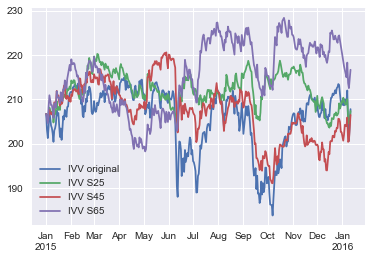

In [151]:
# plot results and 2-norm differences 
pd.Series(ivv_actual.flatten(), index=pd.date_range(start=INSAMPLE_START_DATE, periods = 376,freq='D')).plot(label='IVV original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ivv_predict['calibrate'+str(s)], index=pd.date_range(start=INSAMPLE_START_DATE, periods = 376,freq='D')).plot(label='IVV S'+str(s), legend=True)
    #print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    

In [152]:
# OUT OF SAMPLE

ivv_daily_return_oos_df = get_stock_df(full_price_df, ivv_constituents_list, OUTSAMPLE_START_DATE, OUTSAMPLE_END_DATE)
#ibb_idx_daily_return_df = get_daily_returns(full_price_df, ibb_idx_df, INSAMPLE_START_DATE, INSAMPLE_END_DATE)
ivv_idx_oos_df = pd.DataFrame(ivv_daily_return_oos_df['ivv'])
ivv_daily_return_oos_df = ivv_daily_return_oos_df.drop(columns=['ivv'])
ivv_daily_return_oos_df.head(5)

Empty DataFrame
Columns: []
Index: [AAPL, MSFT, AMZN, FB, JPM]


ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,...,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,0.013121,0.008639,0.008206,-0.001119,0.014100,0.024815,0.030082,0.007939,0.002404,0.006378,-0.002000,-0.001732,0.001546,0.020471,0.017590,0.001145,0.001434,-0.008576,0.009280,0.009173,-0.002914,0.013053,0.009346,0.010306,0.012634,...,0.015987,0.007694,0.0,0.000893,0.013612,0.012334,-0.002836,-0.003179,0.005826,0.015033,0.020027,0.008893,0.032243,-0.002089,0.004431,0.003446,-0.007279,-0.011002,0.008188,0.037736,0.014904,0.003639,0.009194,0.014358,0.009703
2017-01-05,-0.011890,-0.017345,-0.000698,0.005085,0.007584,-0.011576,-0.008035,0.008638,-0.014991,0.016996,-0.014373,-0.007374,-0.005981,-0.008243,-0.007611,0.004958,0.005410,-0.012976,0.004275,-0.006533,0.024448,-0.005609,0.001984,0.000421,0.002268,...,0.000142,0.001357,0.0,-0.015522,0.003020,0.009618,0.003840,0.012117,0.002172,0.004616,-0.004462,0.010447,0.012849,0.011625,0.000000,-0.011358,-0.012108,-0.014907,-0.013029,-0.004196,-0.009129,0.003310,0.006425,-0.016210,-0.003327
2017-01-06,0.031156,0.006973,-0.013091,0.011148,0.000314,0.013384,0.005313,0.027204,0.011392,0.022566,0.003926,-0.022941,0.000679,0.002120,0.030807,0.007590,-0.000791,0.035933,-0.002008,0.003431,-0.007925,0.018445,0.000000,0.008935,0.002263,...,-0.002410,-0.004066,0.0,-0.002537,0.000645,0.006510,-0.005667,0.021424,-0.013726,0.004978,0.011654,-0.003231,0.010827,-0.000714,0.002941,-0.001069,0.019334,-0.000565,-0.000686,-0.015449,-0.007010,0.012097,0.000095,0.006498,0.003152
2017-01-09,0.003126,0.018827,-0.000590,0.009160,0.006584,0.008019,0.014642,-0.000981,-0.011178,0.002493,0.004749,0.000671,-0.006207,0.005374,0.003657,-0.020904,-0.013145,-0.024535,-0.008691,-0.009546,0.004656,-0.006436,-0.010781,-0.019483,-0.013925,...,0.021029,-0.013610,0.0,-0.014535,-0.024127,-0.006074,-0.005841,-0.015114,0.006592,-0.005525,-0.000886,0.003890,0.003462,-0.004643,-0.015152,-0.016849,0.000169,-0.016497,0.003088,-0.005706,-0.004236,0.002794,0.019436,-0.010837,-0.002773


In [158]:
ivv_oos_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

## Build ibb_actual extractor
ivv_oos_actual = get_stock_df(full_price_df, ['ivv'], OUTSAMPLE_START_DATE, OUTSAMPLE_END_DATE, mode='levels').values

#ibb_daily_return_oos_df = ibb_daily_return_df
for non_communal in [15, 35, 55,300]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    #print("stock_index = " + str(stock_index))
    
    x = ivv_daily_return_oos_df.iloc[:, stock_index]
    
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  

    
    # load our trained models
    #print(x)
    deep_learner = load_model('model/retrack_s' + str(s) + '.h5')
 
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage ) + 1
    print(relative_percentage)
    
    # Rebuild the ibb index using start value
    # print(relative_percentage.cumprod() * start_value.values[0])
    ivv_oos_predict['validate'+str(s)] = ivv_oos_actual[0][0] * (relative_percentage.cumprod()) 
    
    #print(len(ibb_oos_predict['validate'+str(s)]))
    #print(ibb_oos_actual.shape)
    
    total_2_norm_diff['validate'+str(s)] = np.linalg.norm((ivv_oos_predict['validate'+str(s)] - ivv_oos_actual))

Empty DataFrame
Columns: []
Index: [ivv]
[[1.        ]
 [0.9984389 ]
 [0.99648863]
 [0.9973214 ]
 [0.972316  ]
 [1.0001645 ]
 [0.99887174]
 [0.9979985 ]
 [0.9989163 ]
 [0.997842  ]
 [0.99480355]
 [0.99648863]
 [1.0033984 ]
 [0.99648863]
 [0.99063903]
 [0.9976167 ]
 [0.99648863]
 [0.99648863]
 [0.99806285]
 [1.009152  ]
 [0.99814636]
 [0.99631095]
 [1.0008353 ]
 [0.99670774]
 [1.0028602 ]
 [0.99958974]
 [1.003525  ]
 [0.9917973 ]
 [0.9955239 ]
 [0.98315364]
 [0.994917  ]
 [0.99648863]
 [1.0041419 ]
 [0.9997609 ]
 [0.99648863]
 [0.9977897 ]
 [0.9970548 ]
 [0.9992071 ]
 [0.9968032 ]
 [0.9977432 ]
 [0.99648863]
 [0.9814989 ]
 [0.99648863]
 [0.99657923]
 [0.99577653]
 [1.0030751 ]
 [0.995307  ]
 [1.0021375 ]
 [0.9954591 ]
 [0.99499947]
 [0.9992905 ]
 [0.99648863]
 [0.99648863]
 [0.99648863]
 [1.0013555 ]
 [0.9990474 ]
 [1.0016819 ]
 [1.0011545 ]
 [1.0048565 ]
 [0.99501145]
 [0.9866484 ]
 [0.9947592 ]
 [1.0011812 ]
 [0.99648863]
 [0.99648863]
 [1.0035987 ]
 [0.9965731 ]
 [0.9975657 ]
 [0.999

[[1.        ]
 [1.0063332 ]
 [1.0237328 ]
 [1.0017995 ]
 [1.0109477 ]
 [0.997643  ]
 [0.9981609 ]
 [1.0044625 ]
 [0.99459606]
 [1.0032953 ]
 [0.99593395]
 [0.99313915]
 [1.0018568 ]
 [0.9962984 ]
 [0.99459606]
 [0.99459606]
 [0.9923136 ]
 [0.99459606]
 [0.9967203 ]
 [1.0092018 ]
 [0.99459606]
 [1.0031642 ]
 [1.0055131 ]
 [0.9995768 ]
 [0.99606884]
 [1.0010501 ]
 [0.9994405 ]
 [0.9941626 ]
 [0.99663025]
 [0.99642223]
 [0.99572265]
 [0.995458  ]
 [0.99869955]
 [0.99956006]
 [0.99205273]
 [1.000468  ]
 [1.0015004 ]
 [0.99678314]
 [0.99930245]
 [0.99296045]
 [1.0020676 ]
 [0.99459606]
 [1.0023472 ]
 [0.9856805 ]
 [0.99696547]
 [0.99485415]
 [0.99872476]
 [0.9997871 ]
 [0.98976123]
 [0.9995259 ]
 [0.9886729 ]
 [0.9937134 ]
 [0.99860954]
 [0.99459606]
 [0.9941571 ]
 [0.99952954]
 [0.99459606]
 [0.99459606]
 [0.99459606]
 [0.99497   ]
 [0.9962611 ]
 [0.99459606]
 [0.9962768 ]
 [0.99825096]
 [0.99667645]
 [0.99916553]
 [0.99112177]
 [0.99988866]
 [0.9970954 ]
 [0.9973354 ]
 [0.99459606]
 [0.99

OSError: Unable to open file (unable to open file: name = 'model/retrack_s310.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# plot results and 2-norm differences 
print(len(ivv_oos_actual.flatten()))
print(len(ivv_oos_predict['validate25']))
print(len(ivv_oos_predict['validate45']))
print(len(ivv_oos_predict['validate65']))
print(total_2_norm_diff['validate25'])
print(total_2_norm_diff['validate45'])
print(total_2_norm_diff['validate65'])
pd.Series(ivv_oos_actual.flatten(), index=pd.date_range(start=OUTSAMPLE_START_DATE, periods = 312,freq='D')).plot(label='IVV original', legend=True)

for s in [25, 45, 65, 310]:
    pd.Series(ivv_oos_predict['validate'+str(s)], index=pd.date_range(start=OUTSAMPLE_START_DATE, periods = 313,freq='D')).plot(label='IVV S'+str(s), legend=True)
    #print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    